In [ ]:
# TODO: Test1

# Laboratory 3: ROC - COVID-19 serological tests

In [201]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Data
**COVID_swab_res**: swab results. Uncertain values are removed, so the only values are
    - 0 -> negative
    - 1 -> positive
**IgG_test1_titre**: test #1 Immunoglobulin G values in range \[2.5, 314]
**IgG_test2_titre**: test #2 Immunoglobulin G values in range \[0, 9.71]

In [60]:
xx = pd.read_csv('covid_serological_results.csv')
# 0 -> negative, 1 -> uncertain, 2 -> positive.
# We want results with only 0 and 1
xx = xx[xx.COVID_swab_res != 1]  # so we remove uncertain results
xx.COVID_swab_res[xx.COVID_swab_res == 2] = 1  # and 2 is then replaced with 1
swab = xx.COVID_swab_res.values
Test1 = xx.IgG_Test1_titre.values
Test2 = xx.IgG_Test2_titre.values

array([[<Axes: xlabel='COVID_swab_res', ylabel='COVID_swab_res'>,
        <Axes: xlabel='IgG_Test1_titre', ylabel='COVID_swab_res'>,
        <Axes: xlabel='IgG_Test2_titre', ylabel='COVID_swab_res'>],
       [<Axes: xlabel='COVID_swab_res', ylabel='IgG_Test1_titre'>,
        <Axes: xlabel='IgG_Test1_titre', ylabel='IgG_Test1_titre'>,
        <Axes: xlabel='IgG_Test2_titre', ylabel='IgG_Test1_titre'>],
       [<Axes: xlabel='COVID_swab_res', ylabel='IgG_Test2_titre'>,
        <Axes: xlabel='IgG_Test1_titre', ylabel='IgG_Test2_titre'>,
        <Axes: xlabel='IgG_Test2_titre', ylabel='IgG_Test2_titre'>]],
      dtype=object)

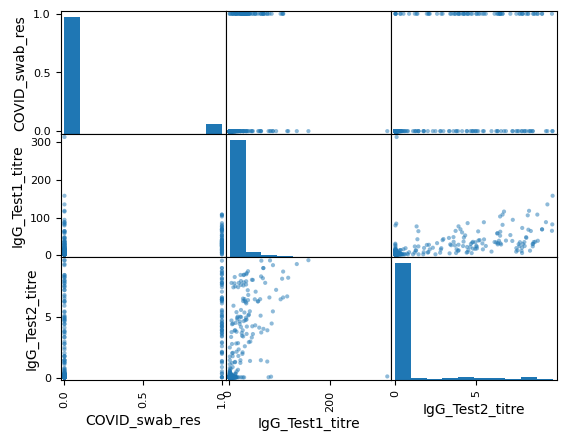

In [61]:
pd.plotting.scatter_matrix(xx)

The plots in the diagonal simply represent the distrution of the values of the i-th test.
The other plots shows, symmetrically along the diagonal, the result of a test given the test value. For example, the first plot in the second row shows the values of Immunoglobulin G for each negative and positive COVID-19 test.

In [62]:
xx.describe()

,COVID_swab_res,IgG_Test1_titre,IgG_Test2_titre
count,862.000000,862.000000,862.000000
mean,0.082367,9.374849,0.803515
std,0.275082,20.431089,2.064172
min,0.000000,2.500000,0.000000
25%,0.000000,2.500000,0.020000
50%,0.000000,2.500000,0.030000
75%,0.000000,5.175000,0.070000
max,1.000000,314.000000,9.690000


### First try
##### Test 1
##### Test 2
A first threshold is arbitrarily set to 5 (giving the results on the PDF); then another threshold is set by computing the percentage of negatives and assuming a linear correlation between Immunoglobine G values and a possible COVID-19 positivity, so that its value is proportional to the percentage of the total negatives.
This threshold will give overall better results.
Formula below:
$threshold = IgG_{min} + {n_{neg}}/{n}IgG_{max}$

In [63]:
x = Test2
y = swab
x1 = x[y == 1]  # Test results for ill patients
x0 = x[y == 0]  # Test results for healthy patients
Np = sum(y == 1)  # Number of ill patients
Nn = sum(y == 0)  # Number of healthy patients
mean = np.mean(y, axis=0)
min_test = min(x)
max_test = max(x)
thresh = min_test + mean * (max_test - min_test)
n1 = np.sum(x1 > thresh)  # Number of true positives
n0 = np.sum(x0 < thresh)  # Number of true negatives
sens = n1 / Np
spec = n0 / Nn
print(f'Threshold set to {thresh}')
print(f'Sensitivity: {sens: .2f}')
print(f'Specificity: {spec: .2f}')

Threshold set to 0.7981322505800464
Sensitivity:  0.90
Specificity:  0.92


In [161]:
def ss_vs_threshold(x, y, threshold_values):
    """
    Computes sensitivity and specificity for a set of threshold values,
    used on a test, and the true results
    """
    x1 = x[y == 1]  # Test results for ill patients
    x0 = x[y == 0]  # Test results for healthy patients
    Np = sum(y == 1)  # Number of ill patients
    Nn = sum(y == 0)  # Number of positive patients
    n1 = np.array([np.sum(x1 > thresh) for thresh in threshold_values])
    n0 = np.array([np.sum(x0 < thresh) for thresh in threshold_values])
    sensitivity_values = n1 / Np
    specificity_values = n0 / Nn
    return [sensitivity_values, specificity_values]

In [162]:
thresholds = np.unique(np.append(0, x[np.argsort(x)]))
tpr, tnr = ss_vs_threshold(x, y, thresholds)
fpr = 1 - tnr

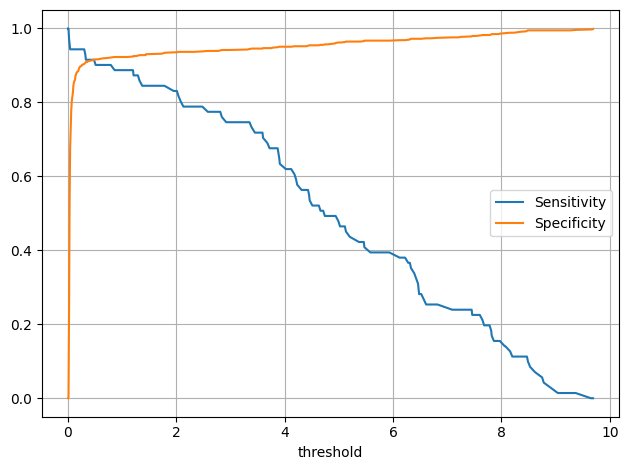

In [163]:
plt.figure()
plt.plot(thresholds, tpr)
plt.plot(thresholds, tnr)
labels = ['Sensitivity', 'Specificity']
plt.xlabel('threshold')
plt.legend(labels)
plt.grid()
plt.tight_layout()
plt.show()

This plot shows that a good working point could be where the threshold is around 0.4, for $P(T_p|D) = P(T_n|H)$.

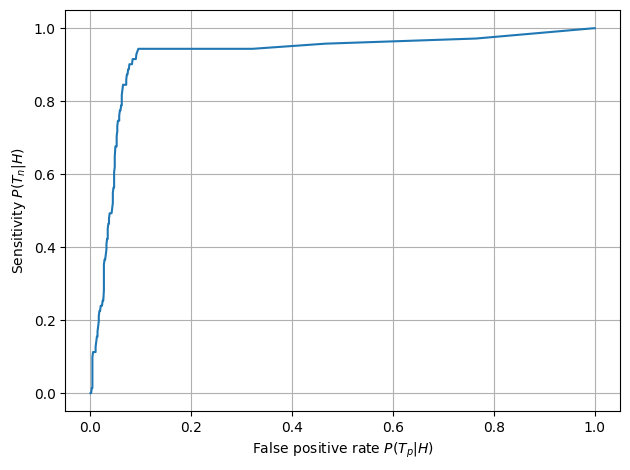

In [164]:
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False positive rate $P(T_p|H)$')
plt.ylabel('Sensitivity $P(T_n|H)$')
plt.grid()
plt.tight_layout()
plt.show()

### Area Under Curve (AUC)
*AUC* is used to know how much a test can be accurate when setting a proper threshold. The ideal value is 1, which would mean that with this test it is possible to detect all positives without false results. Closer values mean better performances.
It is computed with the integral of the ROC curve.

In [165]:
def integral_diy(x, y):
    """
    Calculates the integral of a curve stored in points y vs x using the trapezoidal rule.
    """
    assert len(x) == len(y)
    N = len(x)
    area = 0
    i_sorted = np.argsort(x)
    for i in range(0, N - 1):
        dx = x[i_sorted[i + 1]] - x[i_sorted[i]]
        yi = (y[i_sorted[i]] + y[i_sorted[i + 1]]) / 2
        area += yi * dx
    return area

In [233]:
roc_auc = integral_diy(fpr, tpr)
print(f'Area under ROC (AUC): {roc_auc}')

Area under ROC (AUC): 0.9239240754260073


##### Test 1
##### Test 2
A value of Area under Curve around 0.92 means that the used test is quite precise (using a proper threshold), since we're able to detect a good percentage of true positives without hitting too many false positives.

In [236]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

check_fpr, check_tpr, check_thresh = metrics.roc_curve(y, x, pos_label=1)
check_roc_auc = roc_auc_score(y, x)
print(f'Error on roc_auc: roc_auc - true_roc_auc = {roc_auc - check_roc_auc}')

Error on roc_auc: roc_auc - true_roc_auc = -0.012330620893502564


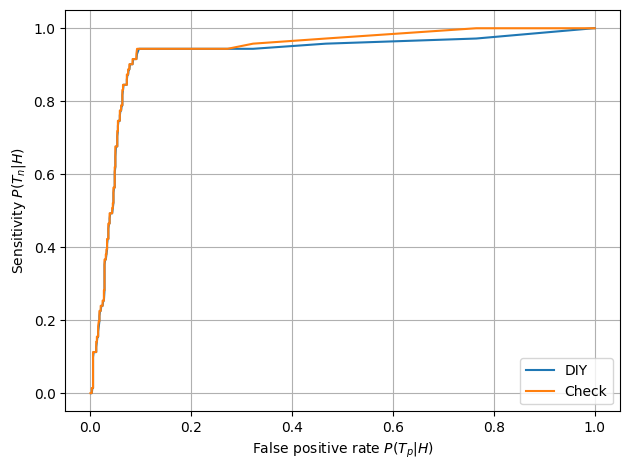

In [237]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot(check_fpr, check_tpr)
plt.xlabel('False positive rate $P(T_p|H)$')
plt.ylabel('Sensitivity $P(T_n|H)$')
labels = ['DIY', 'Check']
plt.legend(labels)
plt.grid()
plt.tight_layout()
plt.show()

### Setting the threshold
The threshold can be set using two policies:
1) Sensitivity equals Specificity ($P(T_p|D) = P(T_n|H)$)
2) Working point ($P(T_p|D)$, $P(T_n|H)$) closest to (1, 0)

#### 1) Sensitivity equals Specificity
This method involves setting the threshold such that in that point $P(T_p|D) = P(T_n|H)$, that is where *sensitivity* and *specificity* curves intersect. Since most likely we don't know at which threshold the two values are equals, we want to find the two points on the x-axis having the *closest values of sensitivity and specificity*, and then we obtain the intersection point of the two lines generated by the four points.

In [238]:
def lines_intersection(r1, r2, s1, s2):
    """
    Finds the coordinates of the point p in which two lines, r and s, intersect.
    The lines are defined as follows:
    r: r1 = (r1x, r1y), r2 = (r2x, r2y)
    s: s1 = (s1x, s1y), s2 = (s2x, s2y)
    """
    mr = (r2[1] - r1[1]) / (r2[0] - r1[0])
    ms = (s2[1] - s1[1]) / (s2[0] - s1[0])
    qr = r1[1] - mr * r1[0]
    qs = s1[1] - ms * s1[0]
    px = (qs - qr) / (mr - ms)
    py = mr * px + qr
    return [px, py]

In [239]:
thresholds_sorted = np.argsort(np.abs(tpr - tnr))
best_ts = [thresholds[thresholds_sorted[0]], thresholds[thresholds_sorted[1]]]
best_sp = [tnr[thresholds_sorted[0]], tnr[thresholds_sorted[1]]]
best_sn = [tpr[thresholds_sorted[0]], tpr[thresholds_sorted[1]]]
intersection_point = lines_intersection(r1=[best_ts[0], best_sp[0]],
                                        r2=[best_ts[1], best_sp[1]],
                                        s1=[best_ts[0], best_sn[0]],
                                        s2=[best_ts[1], best_sn[1]])
best_threshold_1 = intersection_point[0]
best_point_1 = [1 - intersection_point[1], intersection_point[1]]
print(f'Threshold found with method 1: {best_threshold_1}')
print(f'Point on the ROC curve: ({best_point_1[0]: .2f}, {best_point_1[1]: .2f})')

Threshold found with method 1: 0.4861971830985908
Point on the ROC curve: ( 0.08,  0.92)


#### 2) Working point closest to (1, 0)
The second method involves finding the point in the *ROC* curve that is closest to the point (1, 0). To do so, distance from (1, 0) are computed from all the points in the *ROC* curve and the closest is taken.

In [240]:
def eucl_distance(v1, v2):
    assert len(v1) == len(v2)
    v_diff = np.array(v1) - np.array(v2)
    return np.sqrt(v_diff.T @ v_diff)

In [241]:
distances = [eucl_distance([1, 0], [tpr[i], fpr[i]]) for i in range(len(thresholds))]
i_threshold = np.argmin(distances)
best_point_2 = [fpr[i_threshold], tpr[i_threshold]]
best_threshold_2 = thresholds[i_threshold]
best_distance = distances[i_threshold]
print(f'Threshold found with method 2: {best_threshold_2}')
print(f'Point on the ROC curve: ({best_point_1[0]: .2f}, {best_point_1[1]: .2f})')

Threshold found with method 2: 0.3
Point on the ROC curve: ( 0.08,  0.92)


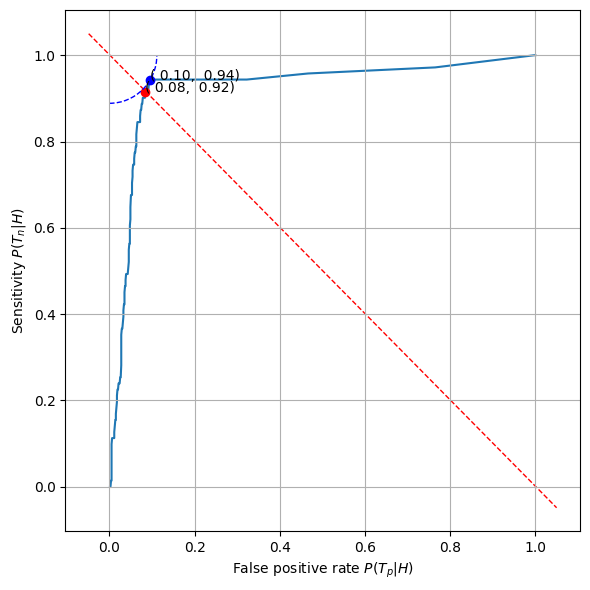

In [242]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, zorder=1)
# Point with the method 1
ax.scatter(best_point_1[0], best_point_1[1], color='r')
ax.text(best_point_1[0], best_point_1[1], f'({best_point_1[0]: .2f}, {best_point_1[1]: .2f})')
v = plt.axis()
ax.plot([v[0], v[1]], [v[1], v[0]], 'r--', linewidth=1, zorder=0)
# Point with the method 2
ax.scatter(best_point_2[0], best_point_2[1], color='b')
ax.text(best_point_2[0], best_point_2[1], f'({best_point_2[0]: .2f}, {best_point_2[1]: .2f})')
ax.add_patch(patches.Arc((0, 1), width=2 * best_distance, height=2 * best_distance, angle=270, theta2=90, facecolor='none', linestyle='--', edgecolor='b'))
plt.xlabel('False positive rate $P(T_p|H)$')
plt.ylabel('Sensitivity $P(T_n|H)$')
ax.grid()
plt.tight_layout()
plt.show()